<b>Target :</b> 

```1. Add Image Augmentation to reduce overfitting and increase network accuracy  ```

In [110]:
!pip install torchsummary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [111]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0,7.0), fill=(1,)),
                                      #  transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [112]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [113]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [114]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

def model_summary():
  model = Net().to(device)
  summary(model, input_size=(1, 28, 28))

cuda


In [115]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [116]:
def plot_result():
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

In [117]:
class Net(nn.Module):

    def conv_block (self, in_channels, out_channels, kernel_size, padding = 1) :
      return nn.Sequential(
            nn.Conv2d (in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(0.02))
        
    def out_block(self, in_channels, kernel_size = 1):
      return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=10, kernel_size = kernel_size, padding = 0, bias = False))


    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = self.conv_block(1, 10, 3)
      self.conv2 = self.conv_block(10, 10, 3, 0)
      self.conv3 = self.conv_block(10, 11, 3)
      self.conv4 = self.conv_block(11, 11, 3, 0)
      self.conv5 = self.conv_block(11, 12, 3)
      self.conv6 = self.conv_block(12, 12, 3, 0)
      self.conv7 = self.out_block(12, 3)
      self.pool = nn.MaxPool2d(2, 2)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

model_summary() 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 26, 26]             900
              ReLU-6           [-1, 10, 26, 26]               0
       BatchNorm2d-7           [-1, 10, 26, 26]              20
           Dropout-8           [-1, 10, 26, 26]               0
         MaxPool2d-9           [-1, 10, 13, 13]               0
           Conv2d-10           [-1, 11, 13, 13]             990
             ReLU-11           [-1, 11, 13, 13]               0
      BatchNorm2d-12           [-1, 11, 13, 13]              22
          Dropout-13           [-1, 11, 13, 13]               0
           Conv2d-14           [-1, 11,

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1050596535205841 Batch_id=468 Accuracy=94.27: 100%|██████████| 469/469 [00:55<00:00,  8.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9829/10000 (98.29%)

EPOCH: 1


Loss=0.03544772043824196 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:57<00:00,  8.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9878/10000 (98.78%)

EPOCH: 2


Loss=0.021754560992121696 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:56<00:00,  8.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


Loss=0.02371998317539692 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:57<00:00,  8.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9915/10000 (99.15%)

EPOCH: 4


Loss=0.009125965647399426 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:57<00:00,  8.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9919/10000 (99.19%)

EPOCH: 5


Loss=0.004215579945594072 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:56<00:00,  8.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.007340621668845415 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:57<00:00,  8.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.010984362103044987 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:56<00:00,  8.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.08225669711828232 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:56<00:00,  8.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.053897757083177567 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:57<00:00,  8.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


Loss=0.02235495299100876 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:56<00:00,  8.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.1073964312672615 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:56<00:00,  8.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.006529020611196756 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:57<00:00,  8.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.013665187172591686 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:56<00:00,  8.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.03420243412256241 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:55<00:00,  8.40it/s]



Test set: Average loss: 0.0229, Accuracy: 9940/10000 (99.40%)



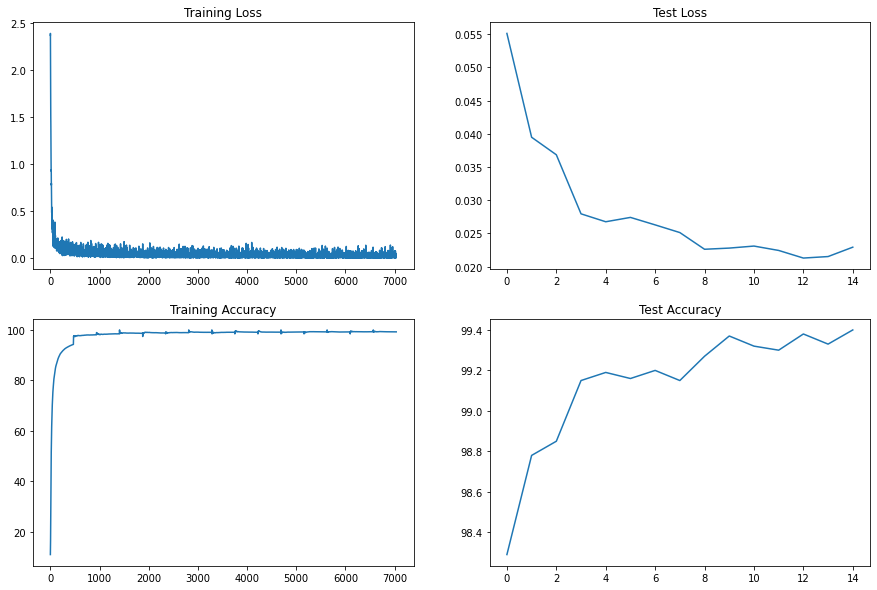

In [118]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

plot_result()

## Results:

<b>Parameters:</b> 6,765

<b>Best Train Accuracy:</b> 99.28

<b>Best Test Accuracy:</b> 99.40

<b>Analysis:</b>
Based on the result we can observe that network is underfitting but that is because we are trying to force our network to learn harder on train data. Using image augmentation has improved our network capacity and was able to achieve required target with 6,765 parameters